C:\Users\AyaKu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
W0519 14:03:07.741000 20176 torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.
Device set to use cpu
C:\Users\AyaKu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\pipelines\text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for

Voici les données:
   admiration  amusement     anger  annoyance  approval    caring  confusion  \
0    0.015715   0.002714  0.016263   0.028799  0.062589  0.139234   0.004838   
1    0.217142   0.004785  0.003526   0.012526  0.072704  0.017524   0.003835   
2    0.014326   0.003286  0.018787   0.055101  0.066028  0.130463   0.009020   
3    0.057006   0.009456  0.017898   0.043780  0.045940  0.088523   0.006901   
4    0.037363   0.011769  0.029315   0.112923  0.099888  0.028615   0.002263   

   curiosity    desire  disappointment  ...  optimism     pride  realization  \
0   0.006148  0.207241        0.031002  ...  0.055826  0.003887     0.016671   
1   0.004961  0.016130        0.011179  ...  0.036361  0.004683     0.016034   
2   0.023539  0.013361        0.032704  ...  0.056240  0.003281     0.024003   
3   0.017047  0.020780        0.095732  ...  0.035830  0.007740     0.029310   
4   0.001882  0.007337        0.059239  ...  0.024440  0.015723     0.042687   

     relief   remor

C:\Users\AyaKu\AppData\Local\Temp\ipykernel_20176\4193172870.py:90: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right", bbox_to_anchor=(1.15,1))


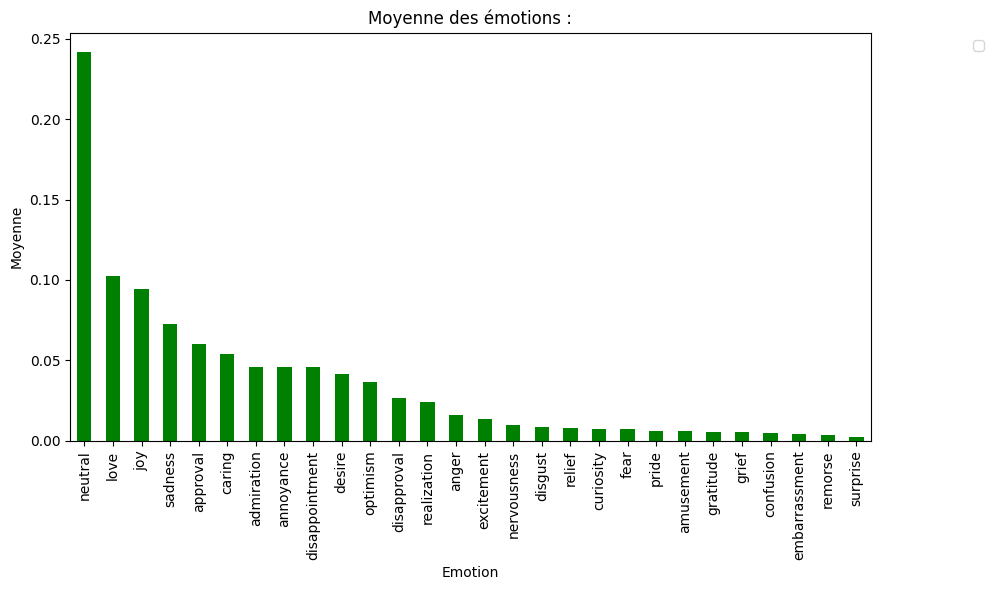

<Figure size 1200x600 with 0 Axes>

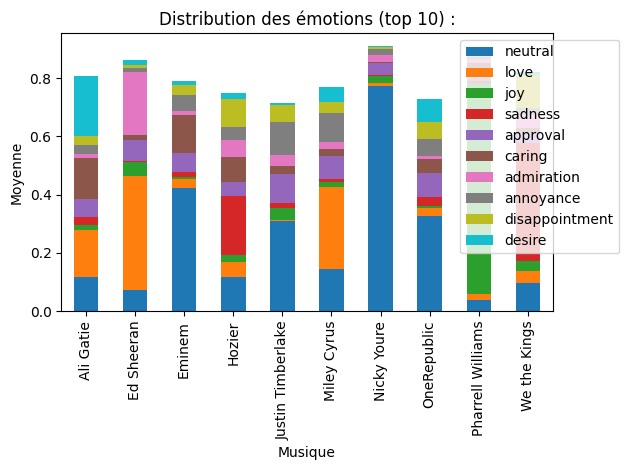

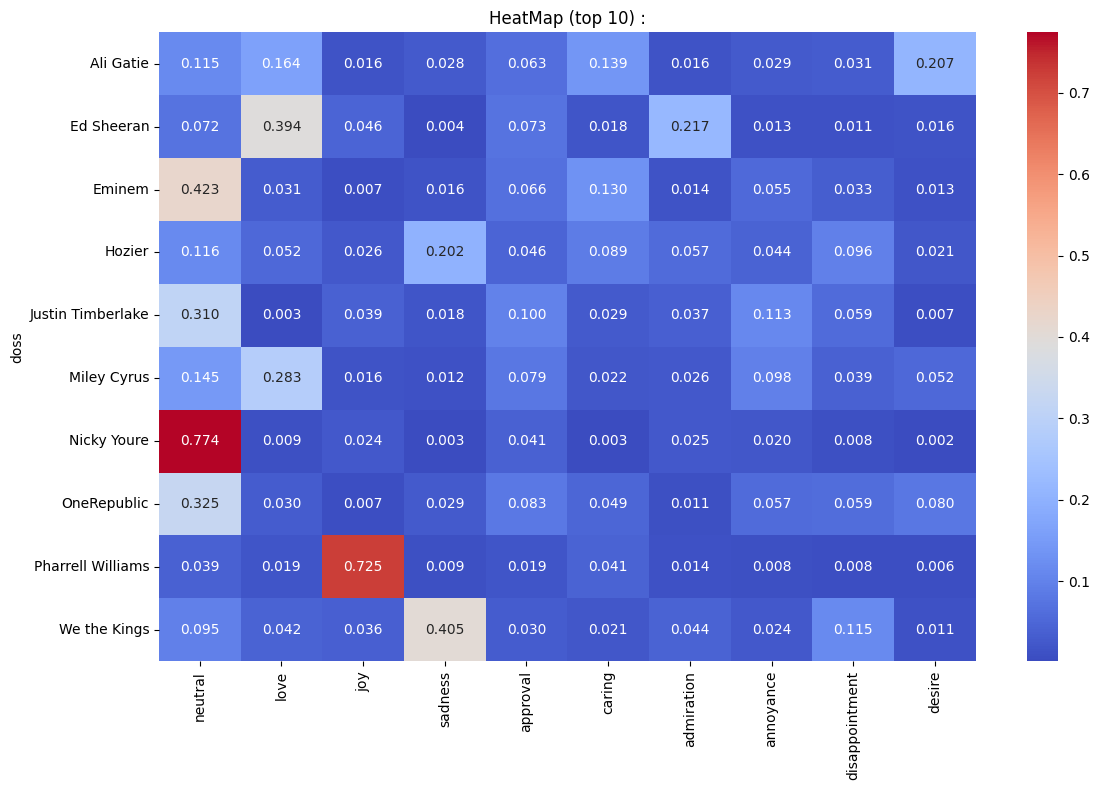

In [1]:
#!pip install transformers
#!pip install torch
#!pip install seaborn
#!pip install matplotlib
#!pip install pandas

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from transformers import pipeline, AutoTokenizer

#Définition d'analyse des emotions et j'utilise un model
def analyse_e(base_path):
    model_n = "bhadresh-savani/bert-base-go-emotion"
    tokenizer = AutoTokenizer.from_pretrained(model_n)
    classifier = pipeline("text-classification", model=model_n, return_all_scores=True)

    results = []

    #Parcourt chaque dossier
    for sousdoss in base_path.iterdir():
        if sousdoss.is_dir():
            for txt_file in sousdoss.glob("*.txt"):
                with open(txt_file, encoding="utf-8") as f:
                    text = f.read()

                tokens = tokenizer.tokenize(text)
                blocks = [
                    tokenizer.convert_tokens_to_string(tokens[i:i+500])
                    for i in range(0, len(tokens), 500)
                ]

                #Variable pour stocker kes scores et les étiquettes
                emotion_score = None
                labels = None

                #Parcours chaque bloc et prédit les émotions
                for block in blocks:
                    preds = classifier(block)[0]
                    scores = np.array([p["score"] for p in preds])
                    if emotion_score is None:
                        emotion_score = scores
                        labels = [p["label"] for p in preds]
                    else:
                        emotion_score += scores

                #Calcule la moyenne et crée un dictionnaire j'ajoute le nom du fichier et du sous dossier
                emotion_avg = emotion_score / len(blocks)
                emotion_dict = dict(zip(labels,emotion_avg.tolist()))
                emotion_dict["filename"] = txt_file.stem
                emotion_dict["doss"] = sousdoss.name
                results.append(emotion_dict)

    df = pd.DataFrame(results)

    emotion_cols = [col for col in df.columns if col not in ["filename","doss"]]
    df[emotion_cols] = df[emotion_cols].apply(pd.to_numeric, errors='coerce')

    return df

#J'indique le chemin et je définis le main et si cela n'existe pas il va me le créer
def main():
    base_path = Path.home() /"PROJECT"/"data"/"clean"
    figures_path = Path.home() /"PROJECT"/"figures"/"MCEmotions"
    figures_path.mkdir(parents=True, exist_ok=True)

    df = analyse_e(base_path)

    print("Voici les données:")
    print(df.head())

    emotion_cols = [col for col in df.columns if col not in ["filename", "doss"]]

    df_grouped = df.groupby("doss")[emotion_cols].mean()

    moyenne_emo = df[emotion_cols].mean().sort_values(ascending=False)

    #Top10
    top10 = moyenne_emo.head(10).index.tolist()
    print("Top 10 émotions :", top10)

    #Graph des Moyennes
    plt.figure(figsize=(10,6))
    moyenne_emo.plot(kind="bar", color="green")
    plt.title("Moyenne des émotions :")
    plt.ylabel("Moyenne")
    plt.xlabel("Emotion")
    plt.legend(loc="upper right", bbox_to_anchor=(1.15,1))
    plt.tight_layout()
    plt.savefig(figures_path / "Moyenne.png")
    plt.show()

    #Moyenne Barres empilées
    plt.figure(figsize=(12,6))
    df_grouped[top10].plot(kind="bar", stacked=True)
    plt.title("Distribution des émotions (top 10) :")
    plt.ylabel("Moyenne")
    plt.xlabel("Musique")
    plt.legend(loc="upper right", bbox_to_anchor=(1.15,1))
    plt.tight_layout()
    plt.savefig(figures_path / "Barreempilé.png")
    plt.show()

    #Moyenne Heatmap 10
    plt.figure(figsize=(12,8))
    sns.heatmap(df_grouped[top10], annot=True, cmap="coolwarm", fmt=".3f")
    plt.title("HeatMap (top 10) :")
    plt.tight_layout()
    plt.savefig(figures_path / "Heatmap.png")
    plt.show()

if __name__ =="__main__":
    main()
